In [1]:
# %pip install "stellargraph[igraph]" chardet -Uq
# %conda install cairocffi

Note: you may need to restart the kernel to use updated packages.


In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import stellargraph as sg
from sklearn.preprocessing import Normalizer
from stellargraph.data import UniformRandomMetaPathWalk
import igraph as ig
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
from python.cogtext.similarity_matrix import get_similarity_matrix

2021-12-06 20:09:16.681839: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:

H = pd.read_csv('models/embeddings/H_USEv4_UMAP5d_v1.csv.gz', index_col=['category','label'])

# normalize
H.iloc[:,:] = Normalizer(norm='l1').fit_transform(H)

FileNotFoundError: [Errno 2] No such file or directory: 'models/embeddings/H_USEv4_UMAP5d_v1.csv.gz'

In [4]:
# cooc: tasks = data.groupby('task')['task_corpus_size'].apply(lambda x: x.iloc[0]).rename('corpus_size').to_frame()
# constructs = data.groupby('construct')['construct_corpus_size'].apply(lambda x: x.iloc[0]).rename('corpus_size').to_frame()
# edges = data[['construct','task','jaccard_coefficient']]
# edges.columns = ['source', 'target', 'weight']

In [42]:
H_sim = get_similarity_matrix(H)
H_sim.columns.name = 'task'
H_sim.index.name = 'construct'
H_sim = H_sim.unstack().reset_index().rename(columns={0:'weight'})

# only high-weighted similarity
edges = H_sim.query('weight > .7')
edges.columns = ['source', 'target', 'weight']

tasks = H.reset_index().query('category == "CognitiveTask"').set_index(['category','label']).reset_index(0,drop=True)
constructs = H.reset_index().query('category == "CognitiveConstruct"').set_index(['category','label']).reset_index(0,drop=True)

G = sg.StellarGraph(
  nodes = {'task': tasks,
           'construct': constructs},
  edges=edges)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 172, Edges: 11340

 Node types:
  task: [100]
    Features: float32 vector, length 234
    Edge types: task-default->construct, task-default->task
  construct: [72]
    Features: float32 vector, length 234
    Edge types: construct-default->construct, construct-default->task

 Edge types:
    construct-default->task: [5472]
        Weights: range=[0.700015, 0.998232], mean=0.859768, std=0.0815104
        Features: none
    task-default->task: [3344]
        Weights: range=[0.70013, 1], mean=0.861541, std=0.0890081
        Features: none
    construct-default->construct: [2524]
        Weights: range=[0.701277, 1], mean=0.866015, std=0.0825268
        Features: none


In [6]:
# ig.plot(ig.Graph.from_networkx(G.to_networkx()))
# nx.draw_spring(G.to_networkx())

In [45]:
# metapath2vec

rnd_walk_length = 3  # maximum length of a random walk

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

rw = UniformRandomMetaPathWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=rnd_walk_length,  # maximum length of a random walk
    n=5,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print(f'Number of random walks: {len(walks)}')

print('\nRandom walks starting from the "Attention" node:')

[' -> '.join(w) for w in walks if w[0] == 'Attention']

Number of random walks: 860

Random walks starting from the "Attention" node:


['Attention -> Cued_Unpredictable_Switch_task -> CentralExecutive',
 'Attention -> Sentence_Completion_task -> Reasoning',
 'Attention -> TowerOfHanoi -> EpisodicMemory',
 'Attention -> TowerOfHanoi -> ContextProcessing',
 'Attention -> ColorShapeTask -> InhibitoryControl']

In [57]:
from gensim.models import Word2Vec

model = Word2Vec(walks, vector_size=256, window=5, sg=1, workers=2, epochs=10000)

model.save('models/cogtext/metapath2vec_v1.202112011.pkl')

print('The metapath2vec model is stored. Graph embedding shape is ', model.wv.vectors.shape)

The metapath2vec model is stored. Graph embedding shape is  (172, 256)


In [71]:
# query most similar tasks or constructs given positive/negative samples
# samples must be valid names from constructs.index and tasks.index

model.wv.most_similar(positive=['BART'],
                      # negative=['InhibitoryControl'],
                      # negative=['TMT_-_Trail_Making_Task']
                      topn=10)

# model.wv.most_similar('LogicalReasoning')

[('ColumbiaCardTask', 0.8800623416900635),
 ('RewardProcessing', 0.7297791242599487),
 ('SelfControl', 0.7268601655960083),
 ('DiscountingTask', 0.6855132579803467),
 ('InformationSampling', 0.6036020517349243),
 ('EmotionalRegulation', 0.5884121656417847),
 ('Delay_Discounting_task', 0.5660563111305237),
 ('ReversalLearning', 0.5628765225410461),
 ('MotivationalDrive', 0.5329203605651855),
 ('Flexibility_Test', 0.49275481700897217)]

In [ ]:
G_embeddings = pd.DataFrame(model.wv.vectors, index=model.wv.index_to_key)
# G_sim = cosine_similarity(G_v)
# G_sim = pd.DataFrame(G_sim, index=G_v.index, columns=G_v.index)
# sns.clustermap(G_sim, figsize=(50,50))
G_embeddings.index.name = 'label'
G_embeddings['category'] = [G.node_type(node_id) for node_id in model.wv.index_to_key]
G_embeddings.reset_index().set_index(['category','label'])
G_embeddings.to_csv('models/cogtext/G_USEv4_UMAP5d_v1.csv.gz')

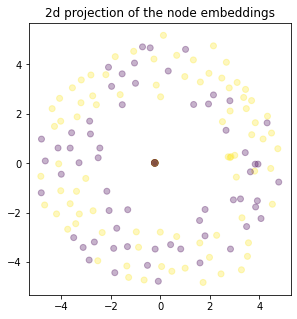

In [ ]:
# visualize in a Euclidean space

node_embeddings = model.wv.vectors
node_types = [G.node_type(node_id) for node_id in model.wv.index_to_key]

from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt


node_embeddings_2d = MDS(n_components=2, metric='cosine').fit_transform(node_embeddings)

label_map = {l: i for i, l in enumerate(np.unique(node_types))}
node_colors = [label_map[t] for t in node_types]

plt.figure(figsize=(5, 5))
plt.axes().set(aspect='equal')
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colors, alpha=0.3)
plt.title('2d projection of the node embeddings')
plt.show()